In [1]:
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2025-03-10 11:52:55.163573: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 11:52:55.173822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741603975.186086  262466 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741603975.189787  262466 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 11:52:55.202545: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
data_arr = np.load("../data/data_unfiltered.npy")
run_arr = np.load("../data/runs_unfiltered.npy")

# Using a reference run
train_data = data_arr[run_arr == 379456]
train_data

array([[1006.,  830.,  253., ...,    0.,    0.,    0.],
       [ 788.,  653.,  221., ...,    0.,    0.,    0.],
       [ 966.,  775.,  295., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [3]:
x_train, x_val = train_test_split(train_data, test_size=0.2)

display(x_train.shape)
display(x_val.shape)

(961, 51)

(241, 51)

In [4]:
class PreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(PreprocessingLayer, self).__init__(**kwargs)

    def call(self, inputs):
        min_val = tf.reduce_min(inputs, axis=0)
        max_val = tf.reduce_max(inputs, axis=0)
        normalized_inputs = tf.where(
            max_val - min_val != 0,
            (inputs - min_val) / (max_val - min_val + 1e-8),
            tf.zeros_like(inputs),
        )
        return normalized_inputs


class MSELoss(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MSELoss, self).__init__(**kwargs)

    def call(self, inputs, targets):
        return tf.math.reduce_mean(tf.math.pow(inputs - targets, 2), axis=1)

In [5]:
class Autoencoder:
    """Autoencoder that reconstruct METSig distributions and flag anomalies"""

    def __init__(self, input_shape: tuple[int], l2_lambda: float):
        input_layer = tf.keras.Input(shape=input_shape)
        prep_layer = PreprocessingLayer()(input_layer)
        encoded = tf.keras.layers.Dense(18, activation="relu", activity_regularizer=tf.keras.regularizers.l2(l2_lambda))(prep_layer)
        encoded = tf.keras.layers.Dense(8, activation="sigmoid")(encoded)
        decoded = tf.keras.layers.Dense(18, activation="sigmoid")(encoded)
        decoded = tf.keras.layers.Dense(input_shape[0], activation="sigmoid")(decoded)
        self.model = tf.keras.models.Model(input_layer, decoded)

        # Since `avg_mse` shares the same layers (prep_layer and decoded) as the `self.model`
        # this `self.inference_model` doesn't need to be trained
        avg_mse = MSELoss()(prep_layer, decoded)
        self.inference_model = tf.keras.models.Model(input_layer, avg_mse)

    def compile(self):
        self.model.compile(optimizer="adam", loss="mse", metrics=["mse"])

    def summary(self):
        self.model.summary()

    def predict(self, inputs: np.ndarray):
        return self.model.predict(inputs)

    def fit(self, inputs: np.ndarray, val_inputs: np.ndarray, batch_size: int, epochs: int):
        targets = PreprocessingLayer()(inputs)
        val_targets = PreprocessingLayer()(val_inputs)
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        history: tf.keras.callbacks.History = self.model.fit(
            inputs,
            targets,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(val_inputs, val_targets),
            callbacks=[es_callback]
        )
        return history

In [6]:
ae = Autoencoder(input_shape=(51,), l2_lambda=1e-4)
ae.compile()
ae.summary()

2025-03-10 11:52:57.065248: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 51)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessing_layer             │ (None, 51)             │             0 │
│ (PreprocessingLayer)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │           936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 18)             │           162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 51)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,219 (8.67 KB)

 Trainable params: 2,219 (8.67 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = ae.fit(x_train, x_val, 128, 200)

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2297 - mse: 0.2172 - val_loss: 0.2140 - val_mse: 0.2055
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2096 - mse: 0.1997 - val_loss: 0.1960 - val_mse: 0.1895
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1912 - mse: 0.1835 - val_loss: 0.1795 - val_mse: 0.1745
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1746 - mse: 0.1682 - val_loss: 0.1642 - val_mse: 0.1604
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1586 - mse: 0.1542 - val_loss: 0.1501 - val_mse: 0.1472
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1443 - mse: 0.1408 - val_loss: 0.1371 - val_mse: 0.1349
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1312 - mse: 0.1284 - val_loss: 0.1251 - val_mse: 0.1234
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1185 - mse: 0.1167 - val_loss: 0.1141 - val_mse: 0.1127
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1078 - mse: 0.1062

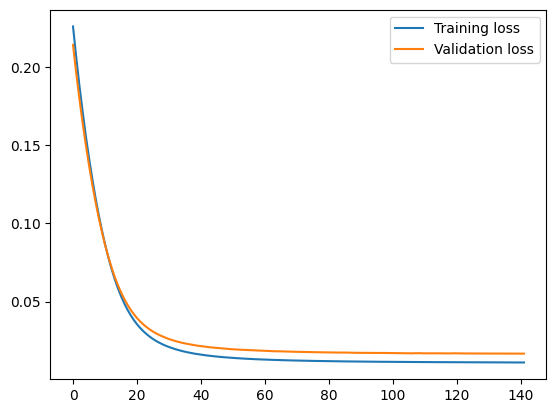

In [8]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.show()

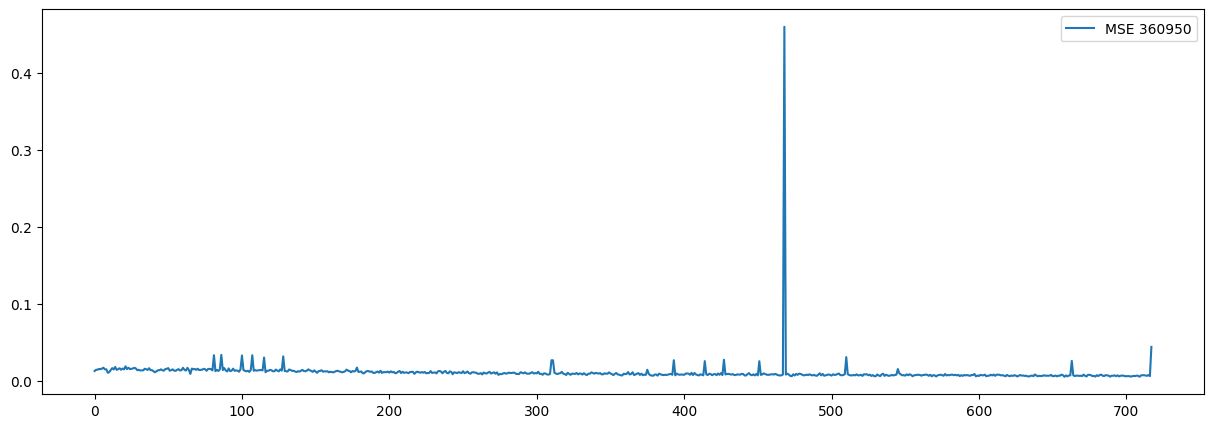

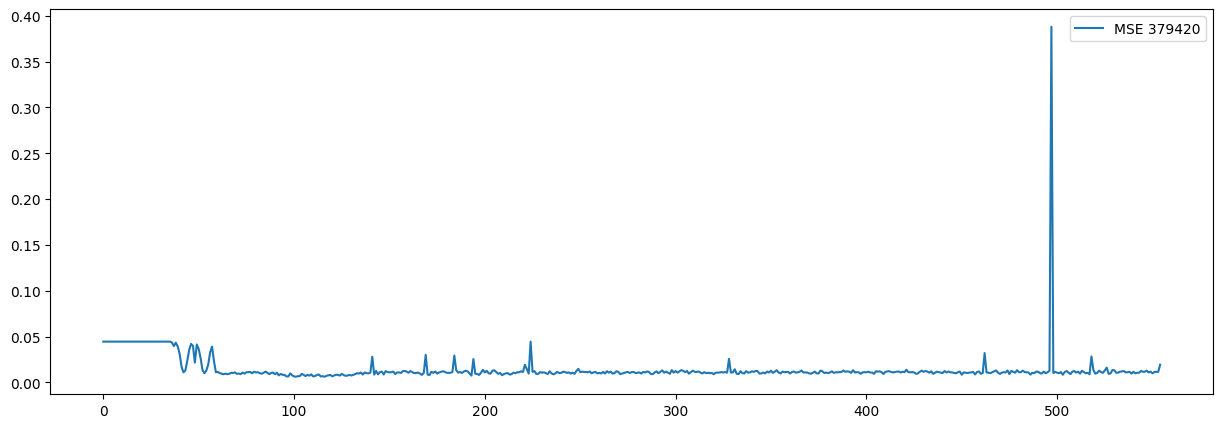

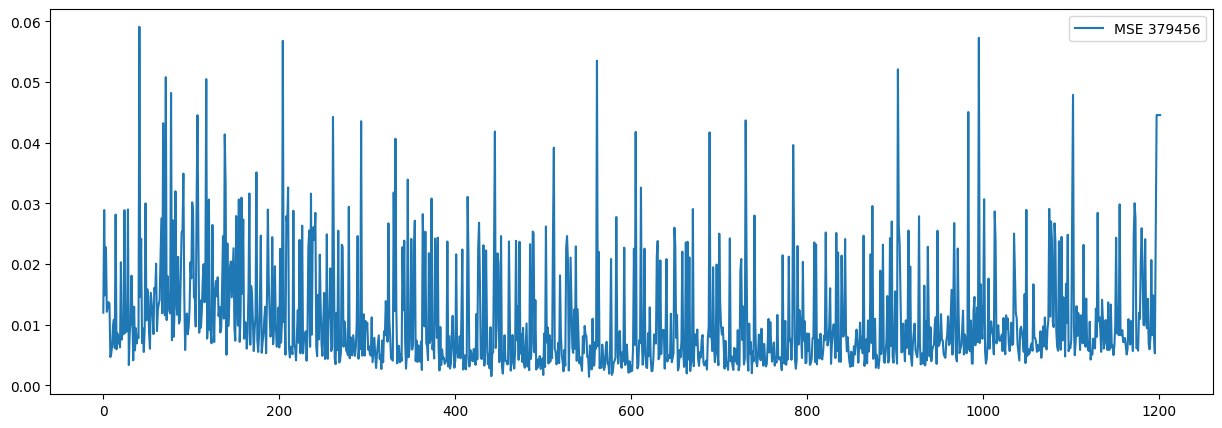

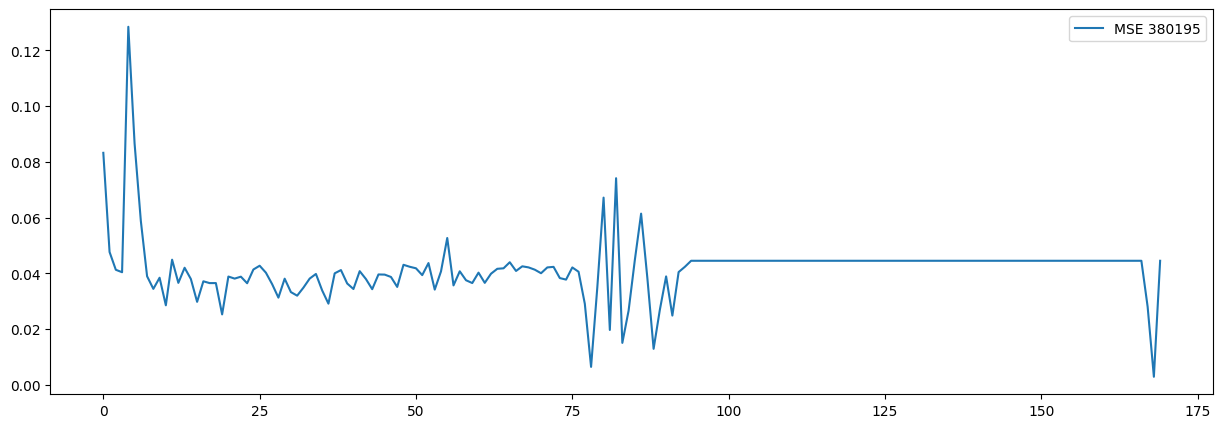

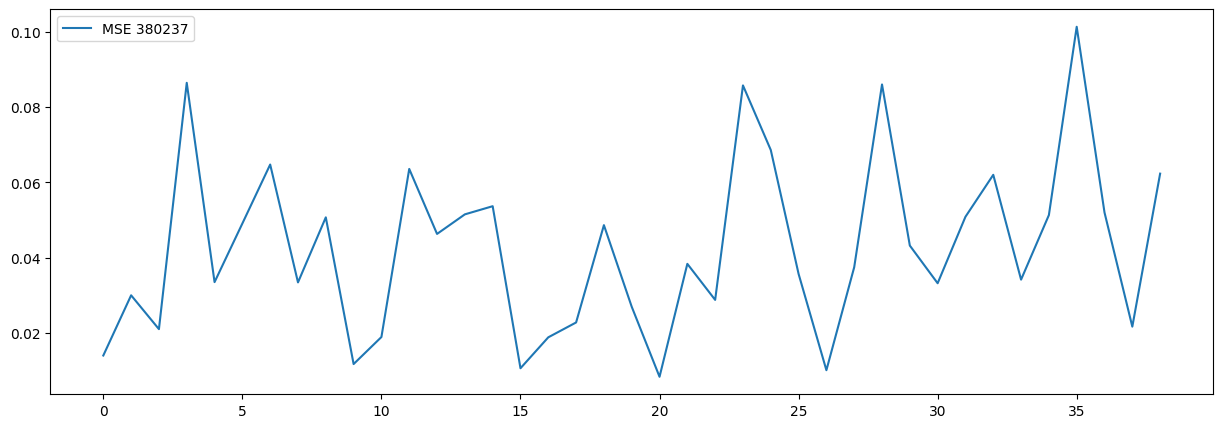

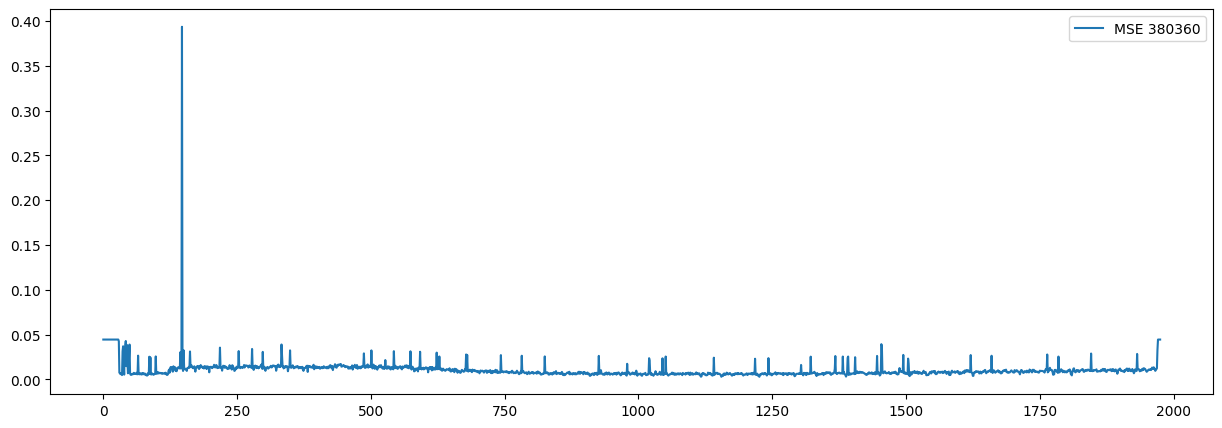

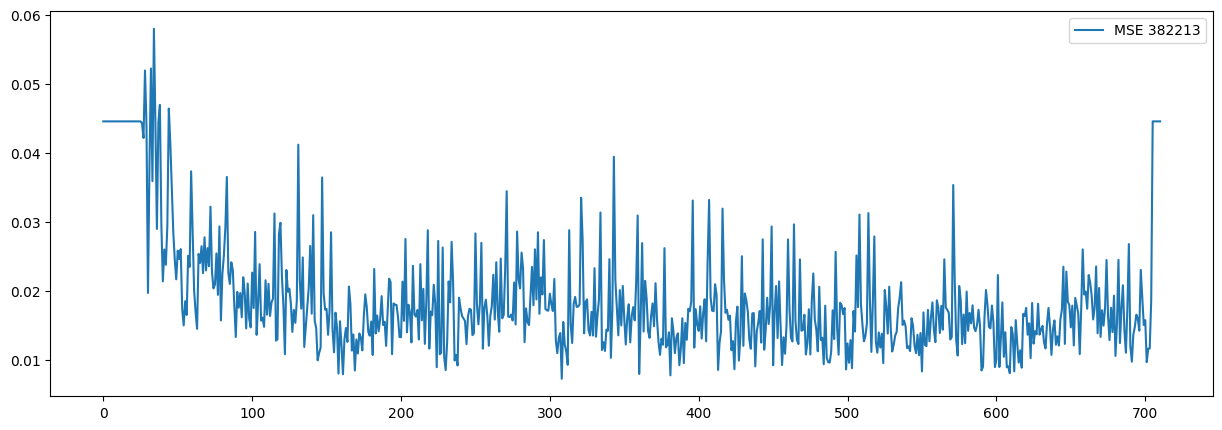

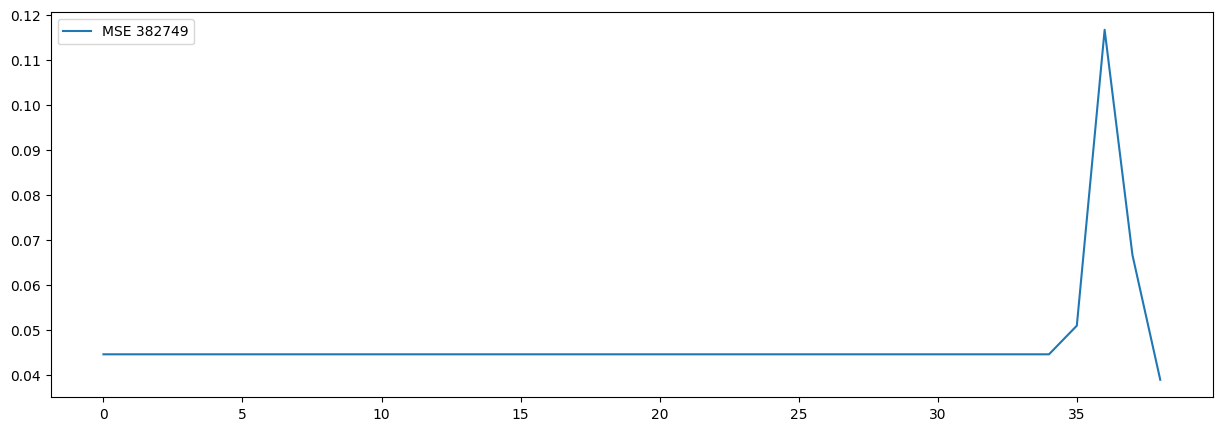

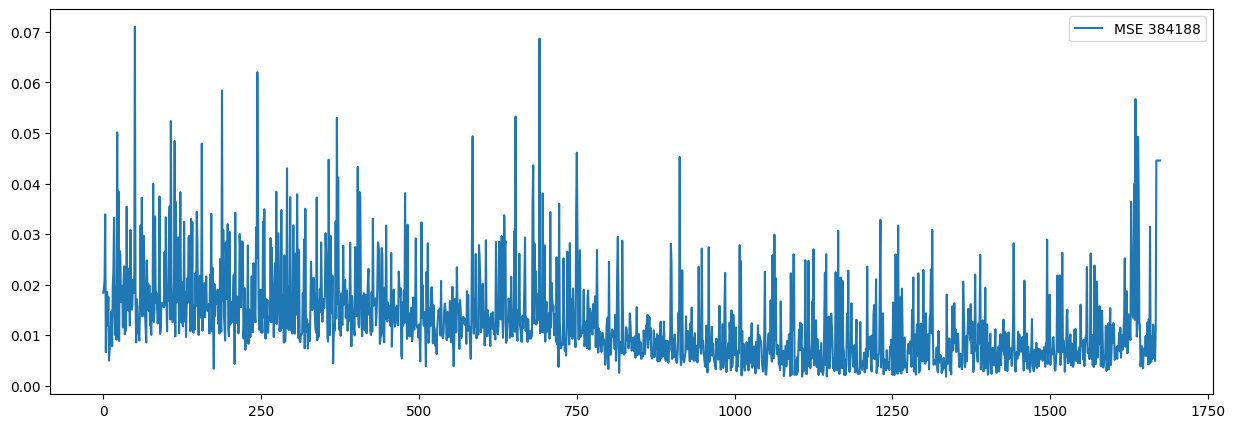

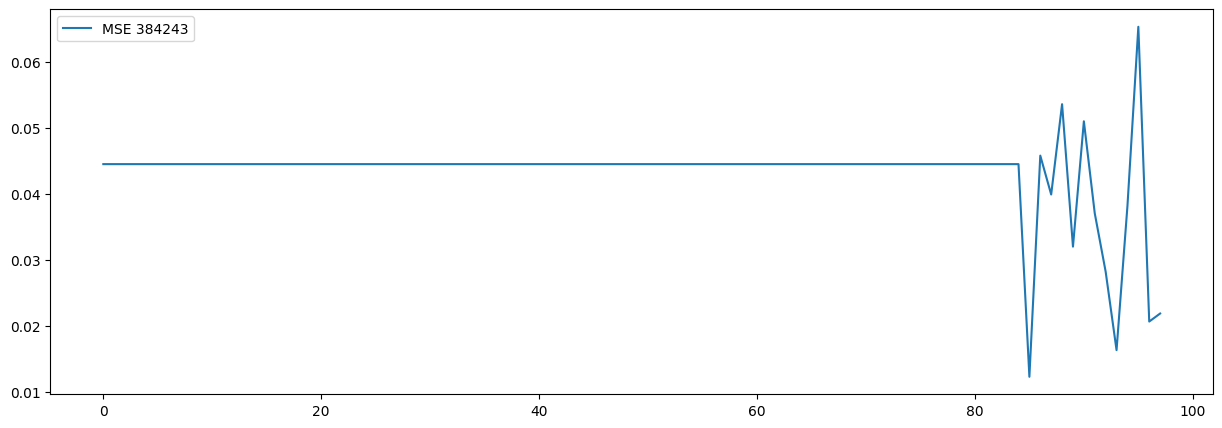

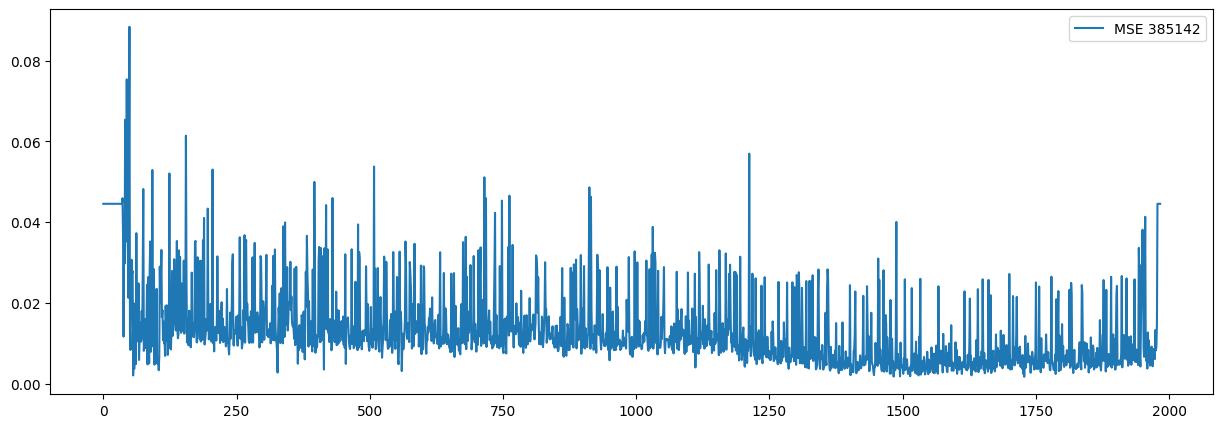

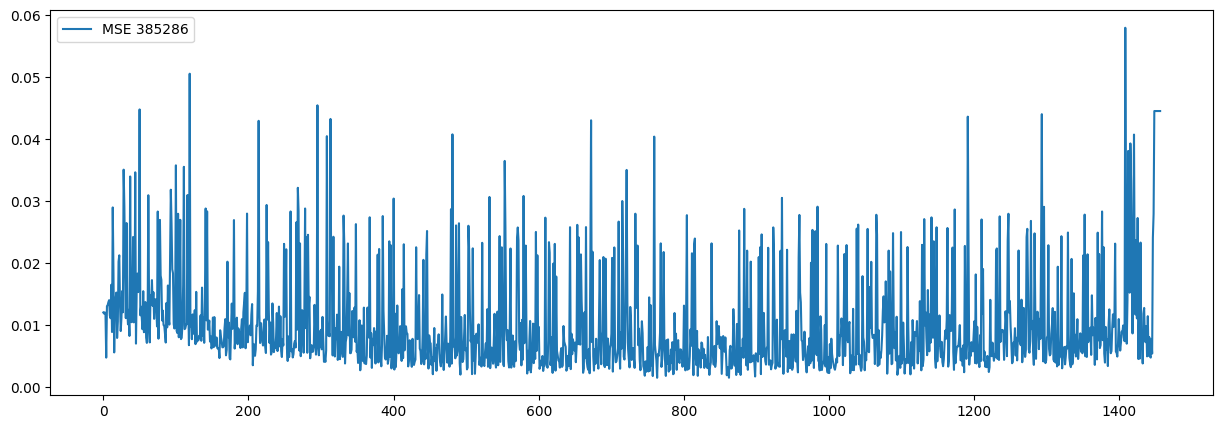

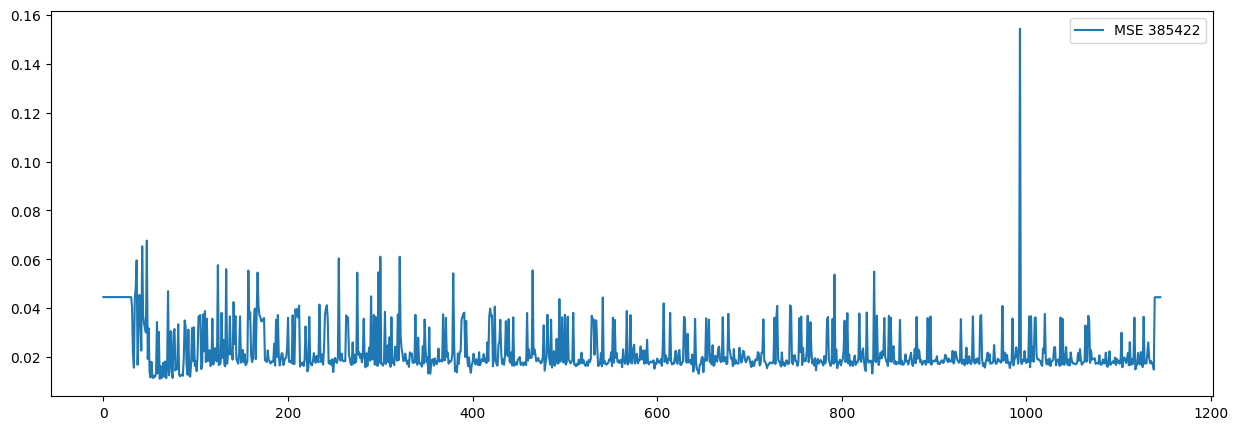

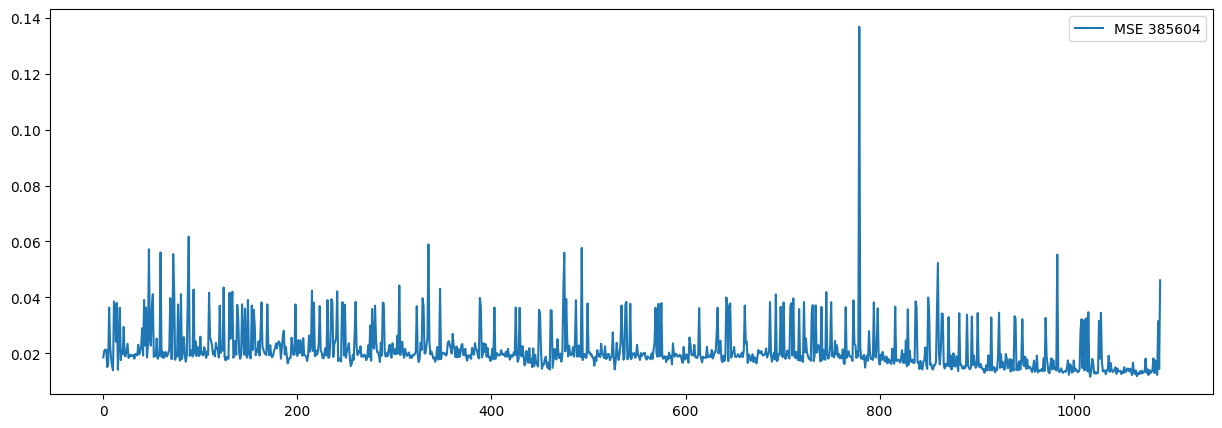

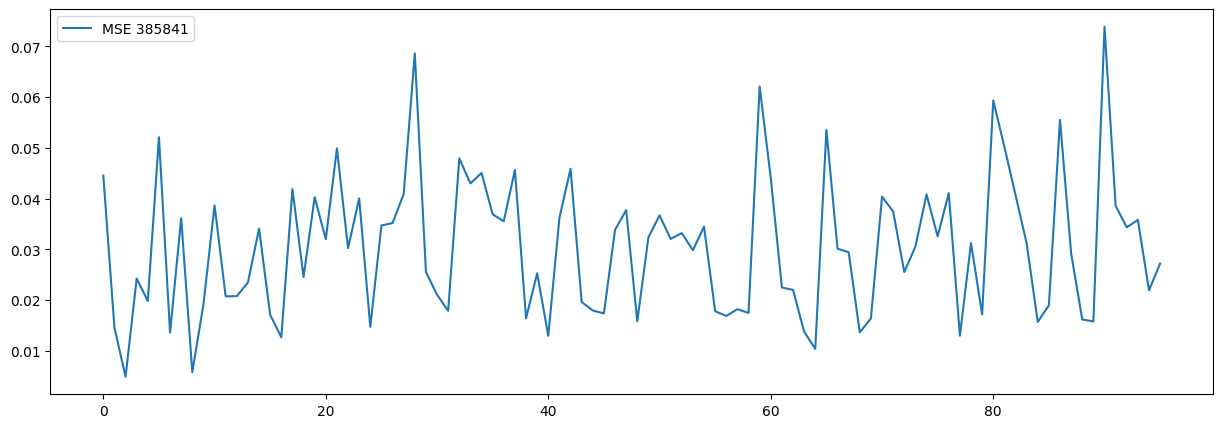

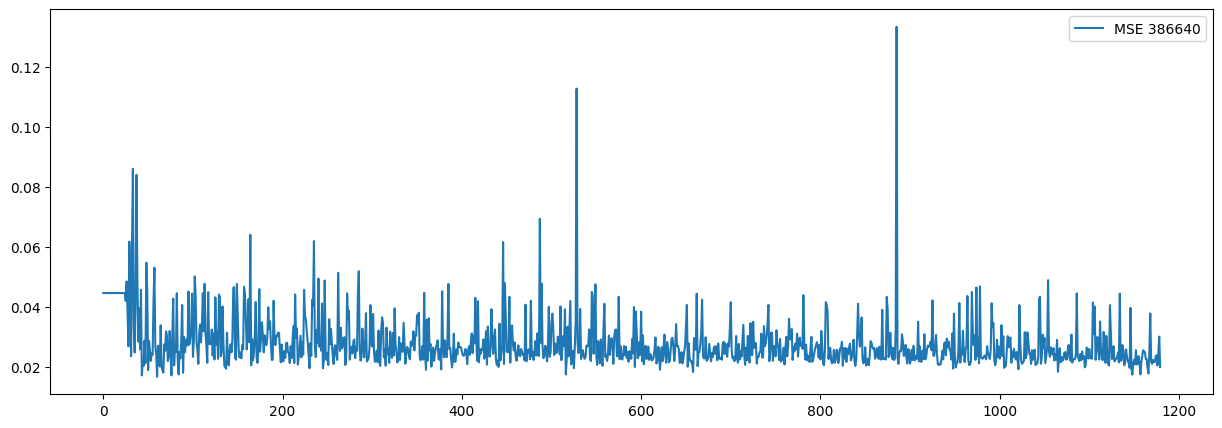

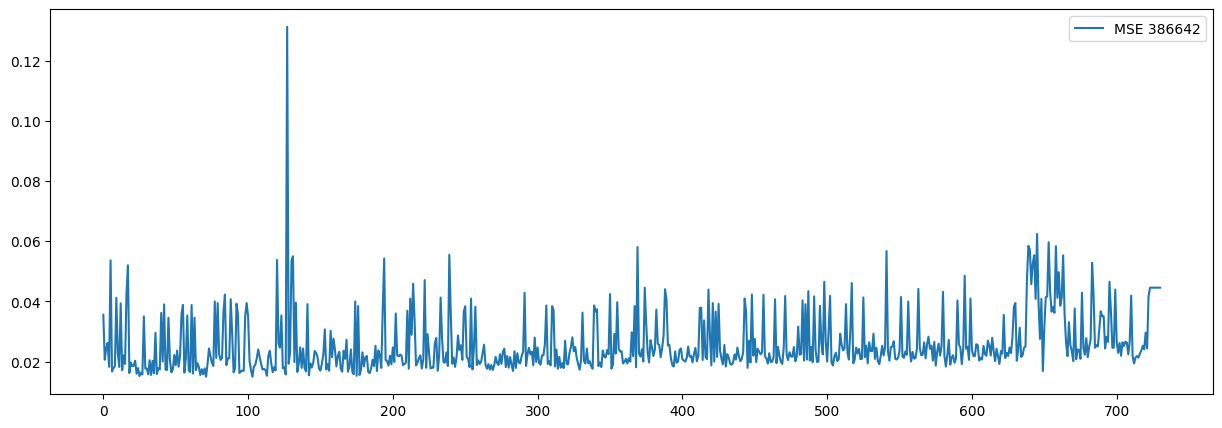

In [9]:
for run_number in np.unique(run_arr):
    test_data = data_arr[run_arr == run_number]
    # mse = ae.inference_model.predict(test_data)  # This will automatically batch input data and then predict
    mse = ae.inference_model.predict_on_batch(test_data)  # This will not batch input data

    plt.figure(figsize=(15, 5))
    plt.plot(range(mse.shape[0]), mse, label=f"MSE {run_number}")
    plt.legend()
    plt.show()
    plt.close()

In [10]:
os.makedirs("../models/tensorflow", exist_ok=True)

model_path = "../models/tensorflow/1/"
tf.saved_model.save(ae.inference_model, model_path)

INFO:tensorflow:Assets written to: ../models/tensorflow/1/assets


INFO:tensorflow:Assets written to: ../models/tensorflow/1/assets
